Guillaume FAURE et Garance LUCAS

# Exercice 1 - Construction de règles contre-factuelles

1. Ensembles de données

In [1]:
import random

import sklearn
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd
import numpy as np
import random
import copy as cp

In [2]:
iris = load_iris()  
X,Y = iris.data, iris.target
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

In [15]:
print(X_train[0])

[5.5 2.4 3.8 1.1]


2. Arbre de décision

In [3]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
arbre = clf.tree_

Classe prédite:  [2 2 0 1 2 1 0 0 1 0 2 2 2 2 1 0 0 1 1 0 1 1 2 0 2 1 0 1 2 0]
Accuracy test:  0.9666666666666667


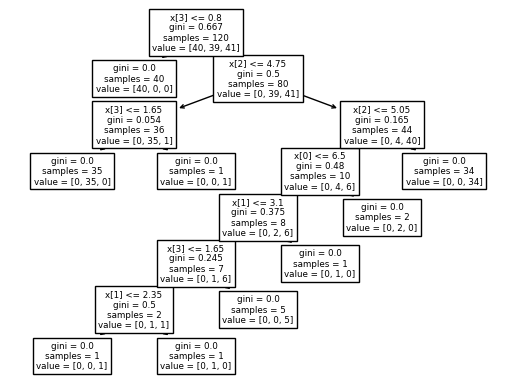

In [4]:
tree.plot_tree(clf)
y_pred = clf.predict(X_test)
print('Classe prédite: ', y_pred)
accuracy = clf.score(X_test, y_test)
print('Accuracy test: ', accuracy)

In [5]:
path = clf.decision_path(X_test)
print(path)

  (0, 0)	1
  (0, 2)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 13)	1
  (1, 0)	1
  (1, 2)	1
  (1, 6)	1
  (1, 16)	1
  (2, 0)	1
  (2, 1)	1
  (3, 0)	1
  (3, 2)	1
  (3, 6)	1
  (3, 7)	1
  (3, 15)	1
  (4, 0)	1
  (4, 2)	1
  (4, 6)	1
  (4, 7)	1
  (4, 8)	1
  (4, 9)	1
  (4, 13)	1
  :	:
  (22, 2)	1
  (22, 6)	1
  (22, 16)	1
  (23, 0)	1
  (23, 1)	1
  (24, 0)	1
  (24, 2)	1
  (24, 6)	1
  (24, 16)	1
  (25, 0)	1
  (25, 2)	1
  (25, 3)	1
  (25, 4)	1
  (26, 0)	1
  (26, 1)	1
  (27, 0)	1
  (27, 2)	1
  (27, 3)	1
  (27, 4)	1
  (28, 0)	1
  (28, 2)	1
  (28, 6)	1
  (28, 16)	1
  (29, 0)	1
  (29, 1)	1


In [6]:
print(arbre.node_count, arbre.feature)

17 [ 3 -2  2  3 -2 -2  2  0  1  3  1 -2 -2 -2 -2 -2 -2]


3. Choix exemple

In [7]:
exemple_index = random.randint(0, len(X_test))
x = X_test[exemple_index]
print('Exemple: ', x)
x_reshape = np.array(x).reshape(1, -1)
y_pred = clf.predict(x_reshape)
print('Classe prédite: ', y_pred)
leaf = clf.apply(x_reshape)
print('Feuille: ', leaf)

path = clf.decision_path(x_reshape)
print("Chemin dans l'arbre: ")
print(path)

# Convertion du chemin en une liste d'indices de nœuds
node_indices = path.indices

feature_names = iris.feature_names

# Règles pour chaque nœud dans le chemin pour x
rules_x = []
for node_index in node_indices:
    node = clf.tree_.value[node_index]  # Valeur du nœud
    feature_index = clf.tree_.feature[node_index]  # Index de la caractéristique testée
    threshold = clf.tree_.threshold[node_index]  # Seuil utilisé pour le test
    
    rules_x.append(f"{feature_names[feature_index]} <= {threshold}")

    if node[0][0] > node[0][1]:
        class_label = "Classe 0"
    else:
        class_label = "Classe 1"

    print(f"Nœud {node_index}: Si la caractéristique {feature_index} <= {threshold}, alors {class_label}")
    
print("Règles pour x: ", rules_x)


Exemple:  [6.3 2.5 5.  1.9]
Classe prédite:  [2]
Feuille:  [13]
Chemin dans l'arbre: 
  (0, 0)	1
  (0, 2)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 13)	1
Nœud 0: Si la caractéristique 3 <= 0.800000011920929, alors Classe 0
Nœud 2: Si la caractéristique 2 <= 4.75, alors Classe 1
Nœud 6: Si la caractéristique 2 <= 5.049999952316284, alors Classe 1
Nœud 7: Si la caractéristique 0 <= 6.5, alors Classe 1
Nœud 8: Si la caractéristique 1 <= 3.100000023841858, alors Classe 1
Nœud 9: Si la caractéristique 3 <= 1.649999976158142, alors Classe 1
Nœud 13: Si la caractéristique -2 <= -2.0, alors Classe 1
Règles pour x:  ['petal width (cm) <= 0.800000011920929', 'petal length (cm) <= 4.75', 'petal length (cm) <= 5.049999952316284', 'sepal length (cm) <= 6.5', 'sepal width (cm) <= 3.100000023841858', 'petal width (cm) <= 1.649999976158142', 'petal length (cm) <= -2.0']


4. Règle contre-factuelles

In [8]:
from sklearn.tree import _tree

def find_paths(tree, node_id, current_path, x_class, leaf_paths):
    """
    Récursivement trouver tous les chemins d'un nœud donné vers les feuilles
    qui ont une classe différente de x_class.
    """
    # Si c'est une feuille
    if tree.children_left[node_id] == _tree.TREE_LEAF:
        # Si la classe de la feuille est différente de x_class
        if tree.value[node_id].argmax() != x_class:
            # Ajouter le chemin à la liste
            leaf_paths.append((current_path, tree.value[node_id].argmax()))
        return

    # Si c'est un nœud interne, appeler récursivement sur les enfants
    if tree.children_left[node_id] != _tree.TREE_LEAF:
        find_paths(tree, tree.children_left[node_id], current_path + [(node_id, 'left')], x_class, leaf_paths)
    if tree.children_right[node_id] != _tree.TREE_LEAF:
        find_paths(tree, tree.children_right[node_id], current_path + [(node_id, 'right')], x_class, leaf_paths)

def get_leaf_paths_for_different_class(clf, x, feature_names):
    """
    Obtenir tous les chemins de l'arbre clf qui mènent à des feuilles
    dont la classe prédite est différente de celle prédite pour l'exemple x.
    """
    # Prédire la classe pour l'exemple x
    x_class = clf.predict([x])[0]

    # Initialiser la liste pour stocker les chemins
    leaf_paths = []
    find_paths(clf.tree_, 0, [], x_class, leaf_paths)

    # Traduire les chemins en règles
    paths_with_rules = []
    for path, class_idx in leaf_paths:
        rules = []
        for node_id, direction in path:
            if direction == 'left':
                threshold = clf.tree_.threshold[node_id]
                feature = feature_names[clf.tree_.feature[node_id]]
                rules.append(f"{feature} <= {threshold}")
            else:
                threshold = clf.tree_.threshold[node_id]
                feature = feature_names[clf.tree_.feature[node_id]]
                rules.append(f"{feature} > {threshold}")
        paths_with_rules.append((rules, clf.classes_[class_idx]))

    return paths_with_rules

# Appliquer la fonction à notre exemple x
paths = get_leaf_paths_for_different_class(clf, x, feature_names)

for rules, class_name in paths:
    print(f"Rules: {rules} => Class: {iris.target_names[class_name]}")

Rules: ['petal width (cm) <= 0.800000011920929'] => Class: setosa
Rules: ['petal width (cm) > 0.800000011920929', 'petal length (cm) <= 4.75', 'petal width (cm) <= 1.6500000357627869'] => Class: versicolor
Rules: ['petal width (cm) > 0.800000011920929', 'petal length (cm) > 4.75', 'petal length (cm) <= 5.049999952316284', 'sepal length (cm) <= 6.5', 'sepal width (cm) <= 3.100000023841858', 'petal width (cm) <= 1.649999976158142', 'sepal width (cm) > 2.350000023841858'] => Class: versicolor
Rules: ['petal width (cm) > 0.800000011920929', 'petal length (cm) > 4.75', 'petal length (cm) <= 5.049999952316284', 'sepal length (cm) <= 6.5', 'sepal width (cm) > 3.100000023841858'] => Class: versicolor
Rules: ['petal width (cm) > 0.800000011920929', 'petal length (cm) > 4.75', 'petal length (cm) <= 5.049999952316284', 'sepal length (cm) > 6.5'] => Class: versicolor


In [9]:
count_chemin = []

for path,_ in paths:
    count = 0
    for rules in rules_x:
        if rules in path:
            count += 1
    count_chemin.append(count)
    
print(count_chemin)

[1, 1, 4, 2, 1]


5. Explication pour la classification d'un exemple

In [10]:
explication = np.argmax(count_chemin)
path_explication = paths[explication]


differences = [(i, a, b) for i, (a, b) in enumerate(zip(path_explication, rules_x)) if a != b]

# Afficher les différences
for _, val1, val2 in differences:
    print(f"valeurs différentes: l'explication a: {val1}, l'exemple a: {val2}")

valeurs différentes: l'explication a ['petal width (cm) > 0.800000011920929', 'petal length (cm) > 4.75', 'petal length (cm) <= 5.049999952316284', 'sepal length (cm) <= 6.5', 'sepal width (cm) <= 3.100000023841858', 'petal width (cm) <= 1.649999976158142', 'sepal width (cm) > 2.350000023841858'], l'exemple a petal width (cm) <= 0.800000011920929
valeurs différentes: l'explication a 1, l'exemple a petal length (cm) <= 4.75


6.  Explication pour classification de x par l'arbre de decision

# Exercice 2 - Generalisation de bases d'apprentissage et d'explications

1. Génération d'une base d'apprentissage pour construire un modele de substitution

In [89]:
def generate_base(x, black_box, N, G, pc, pm, size_sub_pop, Z_equal):
    
    def euclidean_distance(x,z):
        return np.sqrt(np.sum((x-z)**2))
    
    
    def fitness(Z_equal, black_box, x, z, distance = euclidean_distance):
        # print('x attributs: ', x['attributs'])
        # print('z: ', z)
        # print('z attributs: ', z['attributs'])
        x = np.array(x['attributs']).reshape(1, -1)
        z = np.array(z['attributs']).reshape(1, -1)
        pred_x = black_box.predict(x)
        pred_z = black_box.predict(z)
        
        if Z_equal:
            if pred_x == pred_z:
                I1 = 1
            else:
                I1 = 0
                            
        else:
            if pred_x != pred_z:
                I1 = 1
            else:
                I1 = 0

        return I1 + (1-distance(x, z)) - (x == z).all()                
    
    
    def evaluate(population, x, black_box, Z_equal, distance = euclidean_distance):
        for i in range(len(population)):
            population[i]['fitness'] = fitness(Z_equal, black_box, x, population[i], distance)
        return population
    
    
    def select(population, size_sub_pop):
        population_copy = cp.deepcopy(population)
        selected_population = []
        # print('population fitness: ', [x['fitness'] for x in population_copy])
        
        while len(selected_population) < size_sub_pop:
            sample = max(population_copy, key=lambda x: x['fitness'])
            selected_population.append(sample)
            population_copy.remove(sample)
    
        return selected_population
    
    
    def crossover(population, pc):
        new_population = []
        ens_caracteristiques_indices = [i for i in range(len(population[0]))]
        
        # On applique un crossover a pc% de la population
        print('here ', len(population)*pc/100)
        for _ in range(int(len(population)*pc/100)):
            # Selectionner deux parents aleatoirement
            parent1 = np.random.choice(population)
            parent2 = np.random.choice(population)
            while parent1 == parent2:
                parent2 = np.random.choice(population)
            
            # Selectionner deux caracteristiques aleatoirement
            caracteristique1 = np.random.choice(ens_caracteristiques_indices)
            caracteristique2 = np.random.choice(ens_caracteristiques_indices)
            while caracteristique1 == caracteristique2:
                caracteristique2 = np.random.choice(ens_caracteristiques_indices)
                
            # Composer les deux enfants issus du crossover
            child1 = cp.deepcopy(parent1)
            child2 = cp.deepcopy(parent2)
            child1[0][caracteristique1] = parent2[0][caracteristique1]
            child2[0][caracteristique2] = parent1[0][caracteristique2]
            new_population.append(child1)
            new_population.append(child2)
        
        return new_population+population
    
    
    def mutate(population, pm):
        mutated_population = []
        population_copy = cp.deepcopy(population)
        ens_caracteristiques_indices = [i for i in range(len(population[0]))]
        
        # On applique une mutation a pm% de la population
        print('here 2 ', len(population)*pm/100)
        for _ in range(len(population)*pm/100):
            # Selectionner un individu aleatoirement
            ind = np.random.choice(population_copy)
            
            # Selectionner une caracteristique aleatoirement
            caracteristique_indice = np.random.choice(ens_caracteristiques_indices)
            
            # On regarde la valeur min et la valeur max de cette caracteristique
            min_caracteristique = min(population, key=lambda x: x[0][caracteristique_indice])
            max_caracteristique = max(population, key=lambda x: x[0][caracteristique_indice]) 
            
            # Muter l'individu
            ind[0][caracteristique_indice] = np.random.uniform(min_caracteristique, max_caracteristique)
            mutated_population.append(ind)
            population_copy.remove(ind) #est-ce qu'il faut l'enlever de la population ?
    
        return mutated_population+population

    
    # Initialize population
    P = [x for _ in range(N)]
    [evaluate(P, x, black_box, Z_equal) for x in P]

    # Main loop
    i = 0
    while i < G:
        # Selection
        A = select(P, size_sub_pop)

        # Crossover
        B = crossover(A, pc)

        # Mutation
        C = mutate(B, pm)

        # Evaluation
        [evaluate(C, x, black_box, Z_equal) for x in P]

        # Update population
        P = C
        i += 1

    Z = P
    return Z

In [ ]:
exemple_index = random.randint(0, len(X_test))
x = X_test[exemple_index]
print('Exemple: ', x)
x_reshape = np.array(x).reshape(1, -1)
print('x_reshape: ', x_reshape)
y_pred = clf.predict(x_reshape)
print('Classe prédite: ', y_pred)

x = {'attributs': x, 'fitness': 0}

Z_equal = generate_base(x, clf, N=100, G=100, pc=50, pm=50, size_sub_pop=10, Z_equal=True)

Z_diff = generate_base(x, clf, N=100, G=100, pc=50, pm=50, size_sub_pop=10, Z_equal=False)

print('Z equal: ', Z_equal)
print('Z diff: ', Z_diff)

Exemple:  [6.7 3.1 4.4 1.4]
x_reshape:  [[6.7 3.1 4.4 1.4]]
Classe prédite:  [1]
here  5.0
